In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from global_lib import *


%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
seed = 114514

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
xy = np.array([1,1])

In [4]:
rad_norm = lambda angle: angle % (2 * np.pi) / np.pi
above_pi = lambda angle: 1 if 1 < rad_norm(angle) <=2  else -1

is_positive = lambda num: 1 if num > 0 else 0
is_negative = lambda num: 1 if num <= 0 else 0


# 求向量模
def mod(vec: np.ndarray):
    return np.sqrt(np.sum(vec ** 2, axis=-1))

# 求向量方向的单位向量
def dir_e(vec: np.ndarray):
    return vec / mod(vec)

# 求二维平面内向量的法线方向（左手方向）
def normal_2d(vec: np.ndarray):
    assert vec.shape[-1] == 2, "函数只接受二维向量"
    x, y = -vec[..., 1], vec[..., 0]
    return dir_e(np.hstack([x, y]))

# 求两个向量的夹角,角的大小使用弧度表示.（可以使用余弦公式快速求得） cos(theta) = (a dot b) / (mod(a) * mod(b))
def d_theta(vec_a: np.ndarray, vec_b: np.ndarray):
    cos_theta = np.dot(vec_a, vec_b) / (mod(vec_a) * mod(vec_b))
    if isinstance(cos_theta, np.ndarray):
        cos_theta[cos_theta >= 1.0] = 1.0
        cos_theta[cos_theta <= -1.0] = -1.0
    else:
        cos_theta = min(1.0, max(-1, cos_theta))
    return np.arccos(cos_theta)

# 求向量的方向角theta
def dir2theta(direction):
    direction = dir_e(direction)
    cos_dir, sin_dir = direction[0], direction[1]
    if np.equal(cos_dir, 0):
        return direction[1] * np.pi / 2
    else:
        return np.arctan(sin_dir / cos_dir) + is_negative(cos_dir) * np.pi


# 笛卡尔2极坐标
def x_y_2_r_theta(vec: np.ndarray):
    x, y = vec[..., 0], vec[..., 1]
    r = mod(vec[..., :2])
    theta = np.arctan(y/x)
    return np.vstack([r, theta]).T

# 极坐标2笛卡尔
def r_theta_2_x_y(vec: np.ndarray):
    r, theta = vec[..., 0], vec[..., 1]
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.vstack([x, y]).T

In [5]:
tot_length = 8000
path_width = 300
length_range = (800, 1000)
dir_range = (np.pi / 6, np.pi / 3)

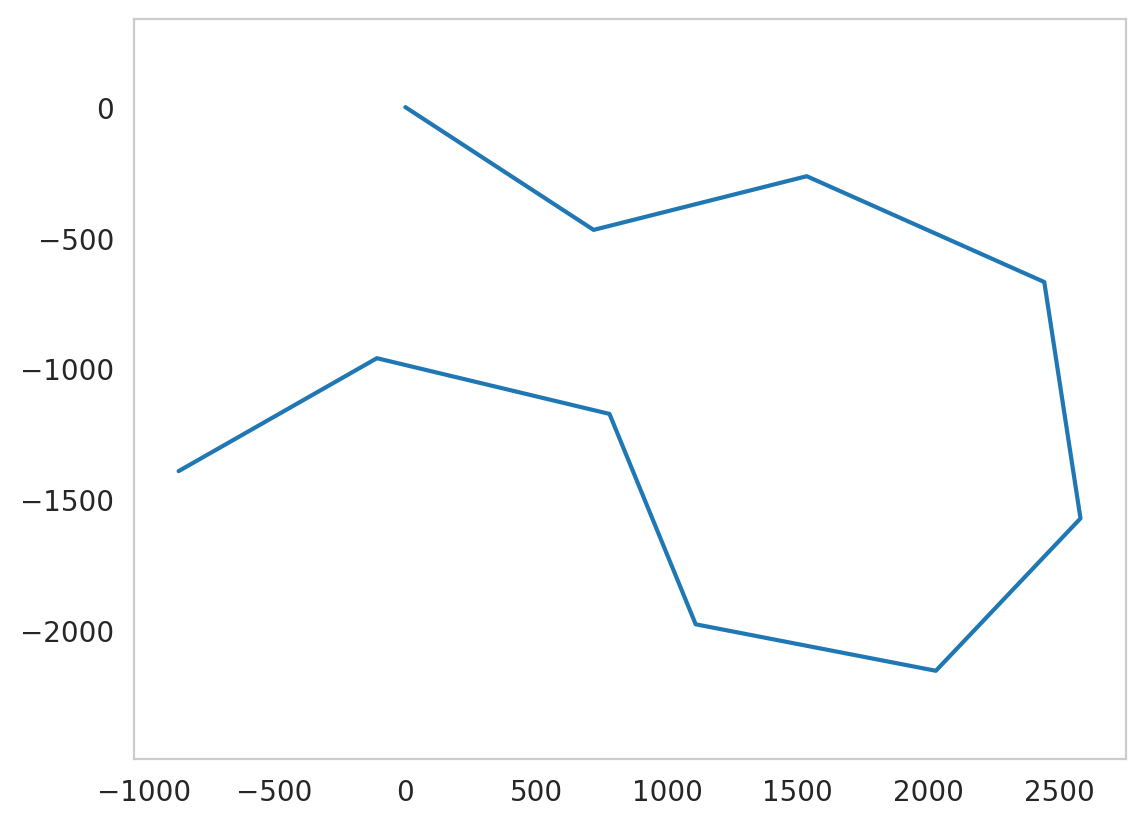

In [6]:
# 随机生成路径
def generate_path():
    path_length = 0
    path_pts = np.zeros([15, 2])
    path_dir = np.zeros([15, 2])
    start_xy = np.array([0, 0])
    direction = 0
    path_pts[0] = start_xy
    point_i = 1
    while path_length < tot_length:
        length = random.randint(*length_range)
        path_length += length
        if (remaining:= tot_length - path_length) < length_range[0]:
            length += remaining
            path_length += remaining

        d_direction = random.random() * abs(dir_range[1] - dir_range[0]) + dir_range[0]
        d_direction *= random.choice([-1, 1])
        direction += d_direction
        ex = np.cos(direction)
        ey = np.sin(direction)
        e = np.array([ex, ey])

        path_pts[point_i] = path_pts[point_i - 1] + e * length
        path_dir[point_i - 1] = np.array([length, direction])

        point_i += 1

    return path_pts[:point_i], path_dir[:point_i - 1]

path_points, path_direction = generate_path()

plt.axis('equal')
plot(path_points[..., 1], path_points[..., 0])

In [7]:
# 通过路径补全道路左右两边
def create_road(path_dir, path_pts, width=path_width):
    half = width / 2
    normal_l = path_dir[..., 1] + np.pi / 2
    l = np.zeros_like(path_pts)
    r = l.copy()

    for i, p in enumerate(path_pts):
        if i == 0:
            l[i] = p + r_theta_2_x_y(np.array([half, normal_l[0]]))
            r[i] = p + r_theta_2_x_y(np.array([half, normal_l[0] + np.pi]))
        elif i == len(path_pts) - 1:
            l[i] = p + r_theta_2_x_y(np.array([half, normal_l[-1]]))
            r[i] = p + r_theta_2_x_y(np.array([half, normal_l[-1] + np.pi]))
        else:
            theta_2 = (path_dir[i, 1] - path_dir[i-1, 1]) / 2
            d_length = np.arctan(theta_2) * half
            length = path_dir[i-1, 0]
            direction = path_dir[i-1, 1]
            l[i] = path_pts[i - 1] + r_theta_2_x_y(np.array([half, normal_l[i - 1]])) + r_theta_2_x_y(np.array([length - d_length, direction]))
            r[i] = path_pts[i - 1] + r_theta_2_x_y(np.array([half, normal_l[i - 1] + np.pi])) + r_theta_2_x_y(np.array([length + d_length, direction]))

    return l, r

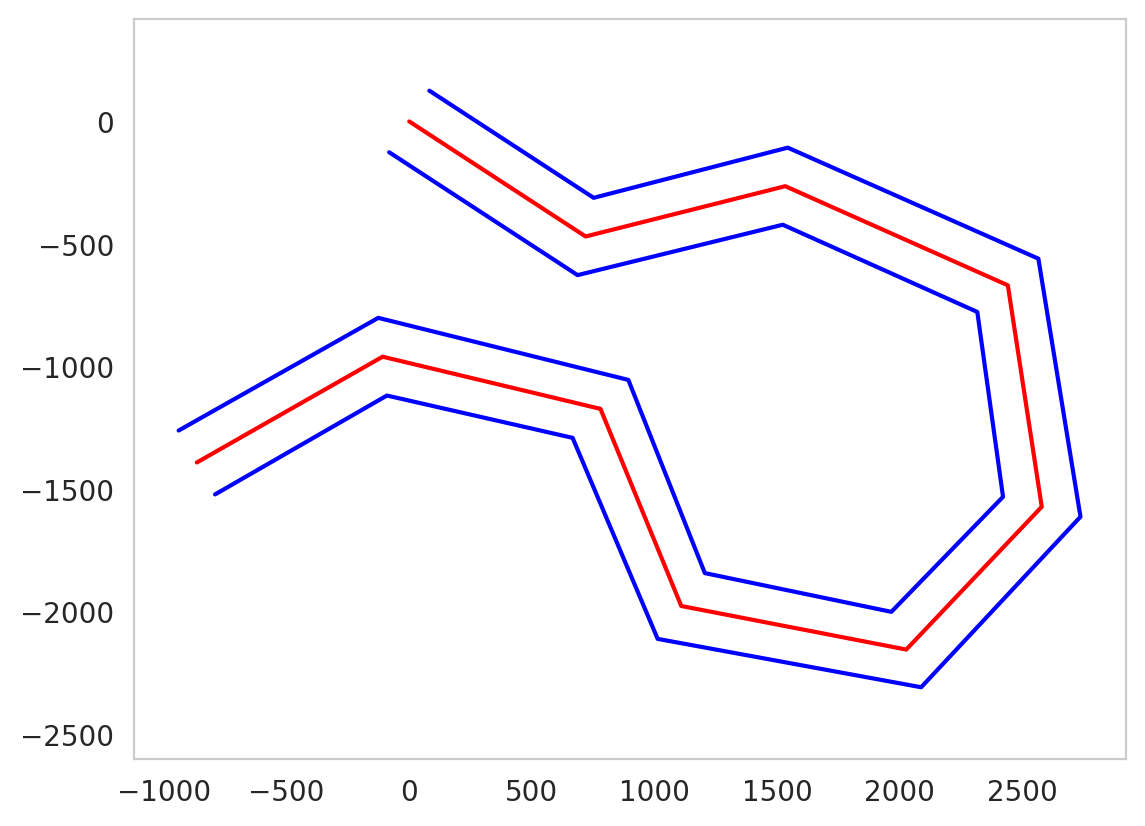

In [8]:
road_l, road_r =create_road(path_direction, path_points)

plt.axis('equal')
plt.grid(0)
plt.plot(*path_points.T, c="r")
plt.plot(*road_l.T, c="b")
plt.plot(*road_r.T, c="b")
plt.show()

# 进一步
有了赛道后，我们需要判断车子（简化为质点）与环境的关系：
1. 是否还在赛道内（不规则多边形）
2. 在哪个直角梯形或等腰梯形内（走到第几段了）
3. 总共完成了总路径的多少（计算点在这一段的中线的投影与段起点的距离+之前已经走过的path的总距离）
4. 车子使用激光雷达，如何判断雷达的射线与多边形的交点。

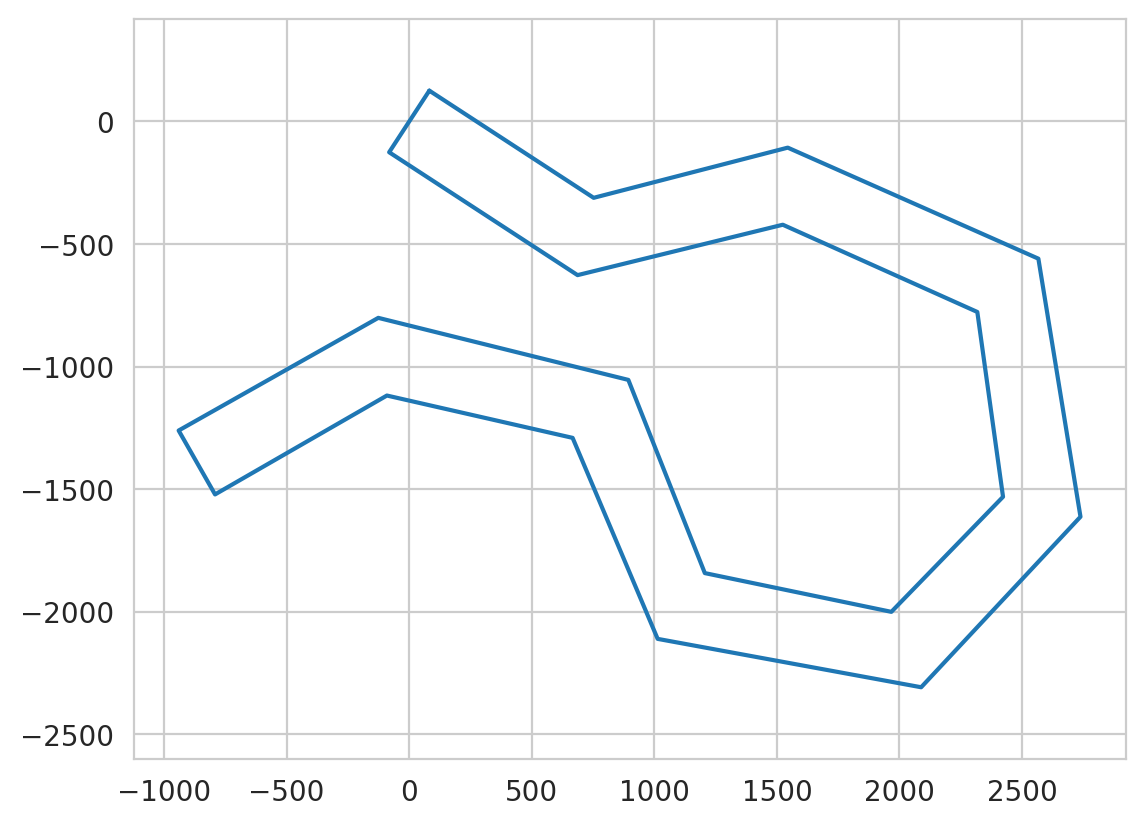

In [9]:
road_polygon = np.vstack([road_l, road_r[::-1], road_l[0]])

plt.axis('equal')
plt.plot(*road_polygon.T)
plt.show()

In [10]:
# 判断是否在凸多边形内(pts的点顺序必须沿顺时针或逆时针，不可乱序)
def in_convex_polygon(p, pts):
    dirs = pts - p
    ang = 0
    for i in range(len(dirs)):
        ang += d_theta(dirs[i], dirs[i-1])
    return np.abs(ang- 2*np.pi) < 1e-7

# test
# quadrangle = road_polygon[[0, 1, -3, -2]]
# in_convex_polygon(np.array([0, 0]), quadrangle)

In [11]:
def in_road(p, road_pts, path_dir=path_direction):
    for i in range(len(path_dir)-1, -1, -1):
        quadrangle = road_pts[[i, i+1, -3-i, -2-i]]
        in_path = in_convex_polygon(p, quadrangle)
        if in_path:
            return i

    return -1

# test
# in_road(path_points[-1], road_polygon)

In [12]:
# 求点在线段上投影的位置（距离line上0点的距离）
def pos_normal(p, line):
    a, b = line[0], line[1]
    ap, pb, ab = p - a, b - p, b - a
    length = mod(ab)

    theta_1 = d_theta(ap, ab)
    theta_2 = d_theta(pb, ab)
    tan1, tan2 = np.tan(theta_1), np.tan(theta_2)

    return length / (1 + (tan1 / tan2))

# test
# pos_normal(np.array([1, 2]), np.array([[0,0], [6,0]])) # 1.0

Index: 8
Completion:  94.837%


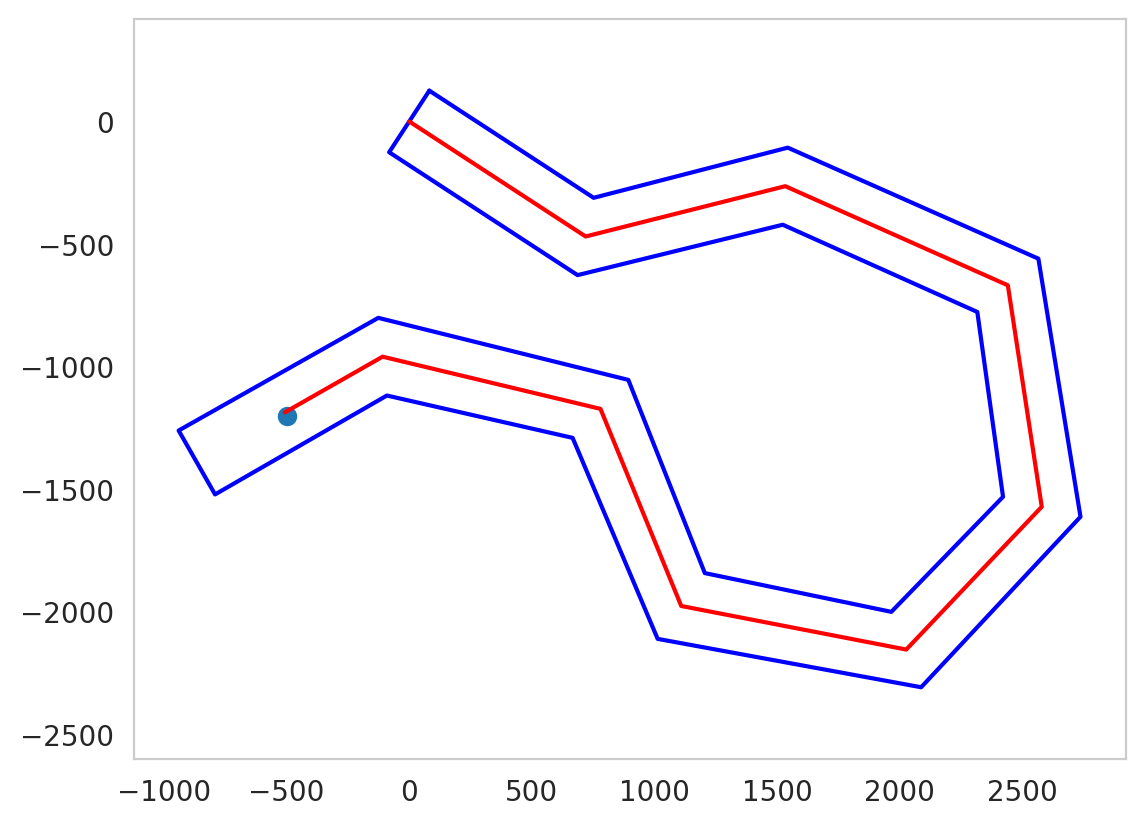

In [13]:
def completion(p, road_pts, path_dir, path_pts):
    ind = in_road(p, road_pts, path_dir)
    if ind == -1:
        return ind, 0, 0
    passed = np.sum(path_dir[:ind, 0])
    line = path_pts[[ind, ind+1]]
    length = pos_normal(p, line)

    return ind, passed+length , length

# test
test_point = np.array([-500, -1200])
path_ind, tot_passed, path_passed = completion(test_point, road_polygon, path_direction, path_points)
print(f"Index: {path_ind}\nCompletion: {tot_passed / tot_length * 100 : 03.3f}%")
# print(path_passed)

in_way = path_points[path_ind] + r_theta_2_x_y(np.array([path_passed, path_direction[path_ind, 1]]))
comp = np.vstack([path_points[:path_ind+1], in_way])

plt.axis('equal')
plt.grid(0)
plt.plot(*road_polygon.T, c="b")
plt.scatter(*test_point)
# plt.plot(*road_l.T, c="b")
# plt.plot(*road_r.T, c="b")
plt.plot(*comp.T, c="r")
plt.show()

# 继续

环境(Environment)基本ok，下面还有激光雷达的数学模型构建（本模型采用正前方0度，向左向右每间隔30度放置激光雷达，扫描的距离上限为道路宽度），以及质点运动模型的构建

---

## 运动转向模型

需要明确的是，质点运动不能随意的改变下一时刻的方向，应该严格遵循[阿克曼转向模型](https://blog.csdn.net/weixin_47012067/article/details/121097901)，也就是即使立刻猛打方向，方向也不能突变，而是沿着该方向舵以及车身属性对应曲率半径R的圆，以该时刻的瞬时速度为线速度，$\!\mathrm{d} t$时间扫过的转向角为$\!\mathrm{d} \theta$，同时下一个时刻的速度方向也要改变$\!\mathrm{d} \theta$。

如图：
![](https://img-blog.csdnimg.cn/803d918edb4e4d58bc103dcdb698cd32.png#pic_center)

# 车车（智慧体Agent以及约束其环境的进一步说明）

我们假设：
+ 车本身可以简化为质点，不考虑车的长度，车的结构以及整体刚度，*转向模型简化为只需控制车运动的曲率半径R*，在车速的影响下，下一个时刻的方向由当前方向，速度和曲率半径共同决定。
+ *车的速度、角速度、位移、角位移均不可突变*，我们将车的油门+刹车组合简化为只需控制*输出的加速度*，在环境耗散（动摩擦(常数f)、风阻（与$v^2$成比例））的影响下，最大速度也会很快收敛。
+ 车没有变速系统，不可倒车，当车速为0时，即使控制输出加速度为负值，速度仍为0；因为没有变速系统，故不存在高速、高扭距等各种模式，智慧体*能且仅能改变$v \geq 0$时刻的加速度*

In [14]:
# 激光雷达，左 -> 右
radar_directions = (np.pi/3, np.pi/6, 0, -np.pi/6, -np.pi/3) # 60° 30° 0° -30° -60°

# 动作选择只针对于Q-Learning组成Q-table；对于DQN，面对环境选择的action可以是取指范围内的任意数。

# 曲率半径选择 0为无穷大的曲率半径，即走直线,+为左转,-为右转
R = [1, 2, 4, 8]
R = [i * path_width for i in R] + [0] + [-i * path_width for i in reversed(R)]
print("R = ", R)

# 油门和刹车组合的输出加速度
acc_input = [-0.8, -0.5, -0.3, 0, 0.3, 0.6, 1]

R =  [300, 600, 1200, 2400, 0, -2400, -1200, -600, -300]


In [15]:
k = 5
f = -0.15
miu = -0.005
dt = 0.5

def acc(gas_brake, velocity):
    a = k * gas_brake + miu * velocity ** 2 + f
    if velocity <= 0 and a <= 0:
        return 0
    else:
        return a

# 制动所需要的周期和制动距离

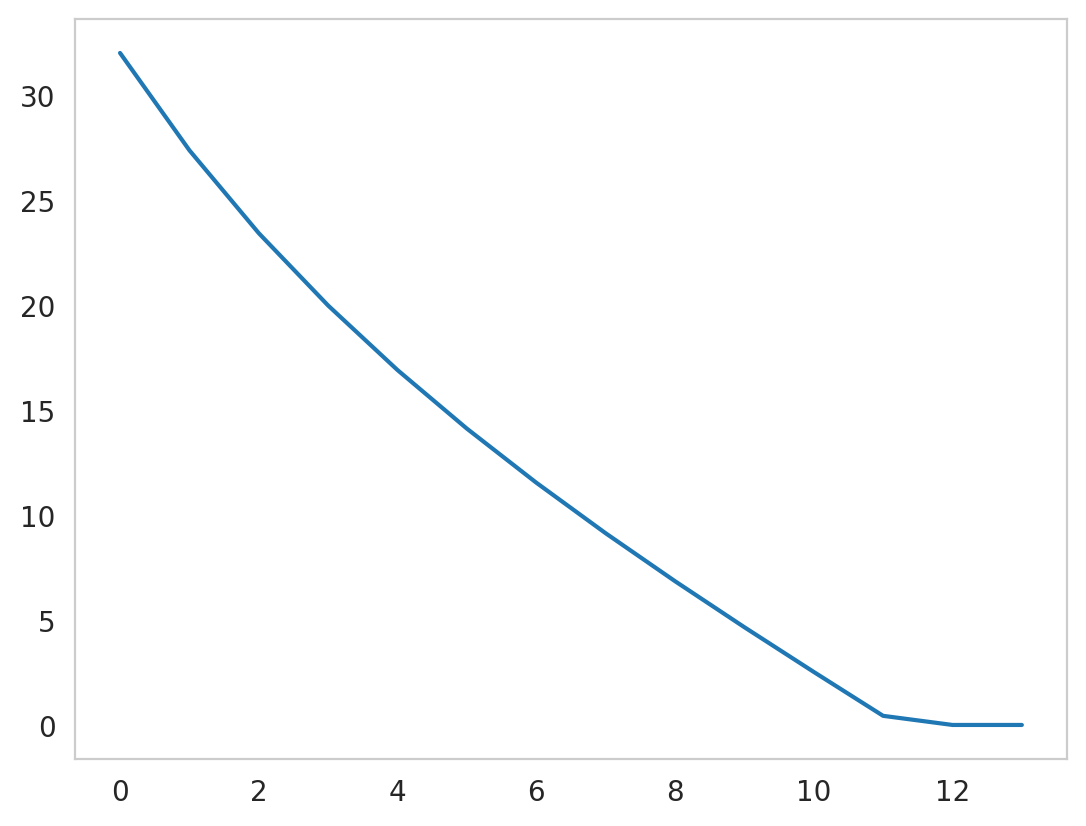

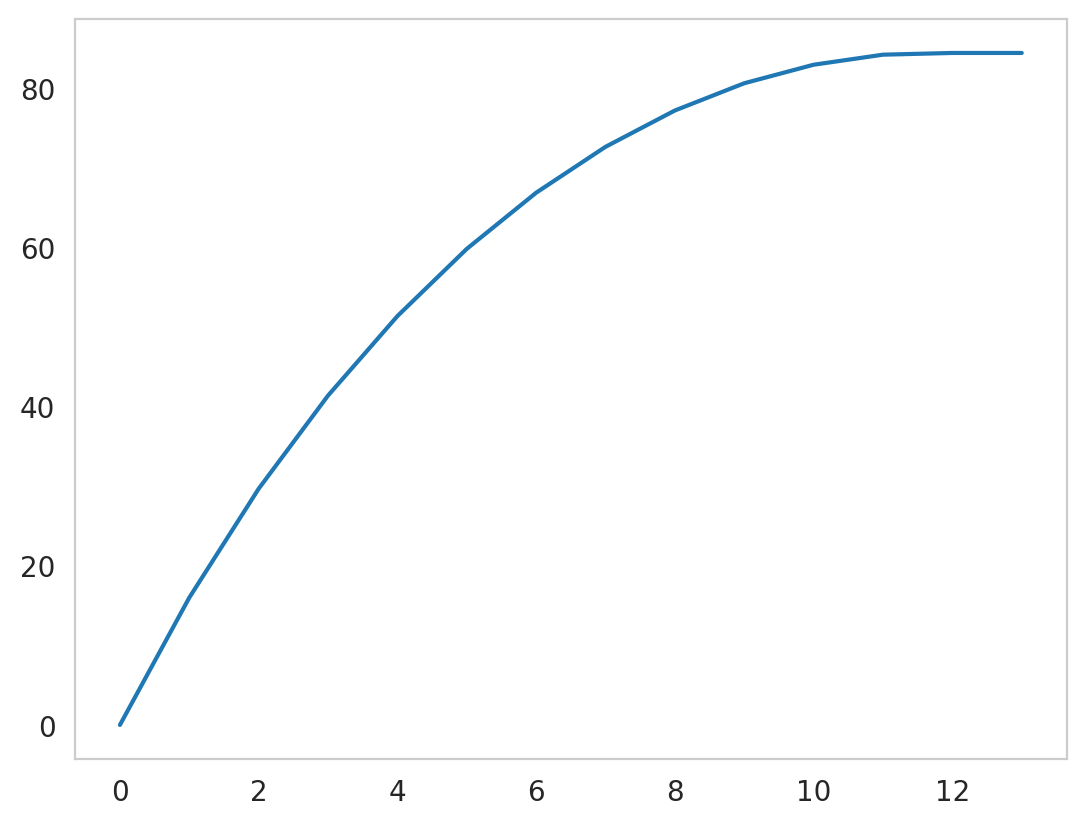

In [16]:
v = [-1, 32]
s = [0]
while abs(v[-2] - v[-1]) > 1e-6:
    acceleration = acc(acc_input[0], v[-1])
    v.append(max(v[-1] + acceleration * dt, 0))
    s.append(s[-1] + v[-2] * dt)
    # print(v[-1])

plot(np.array(v[1:]))
plot(np.array(s))

# 选择转弯的曲率半径后，以速度v运行至下一个$ \!\mathrm{d}t$，并更新方向和位置

In [17]:
def step_next(p, radius, velocity, direction):
    direction = dir_e(direction)
    cos_dir, sin_dir = direction[0], direction[1]
    if radius == 0:
        return p + direction * velocity * dt, direction

    theta = velocity * dt / radius
    # 曲率圆圆心C
    # c = p + radius * normal_2d(direction)

    d_tau = radius * np.sin(theta)
    d_n = radius * (1 - np.cos(theta))
    dp = direction * d_tau + normal_2d(direction) * d_n

    dir_theta = dir2theta(direction)
    new_theta = dir_theta + theta
    new_dir = np.array([np.cos(new_theta), np.sin(new_theta)])

    return p + dp, new_dir

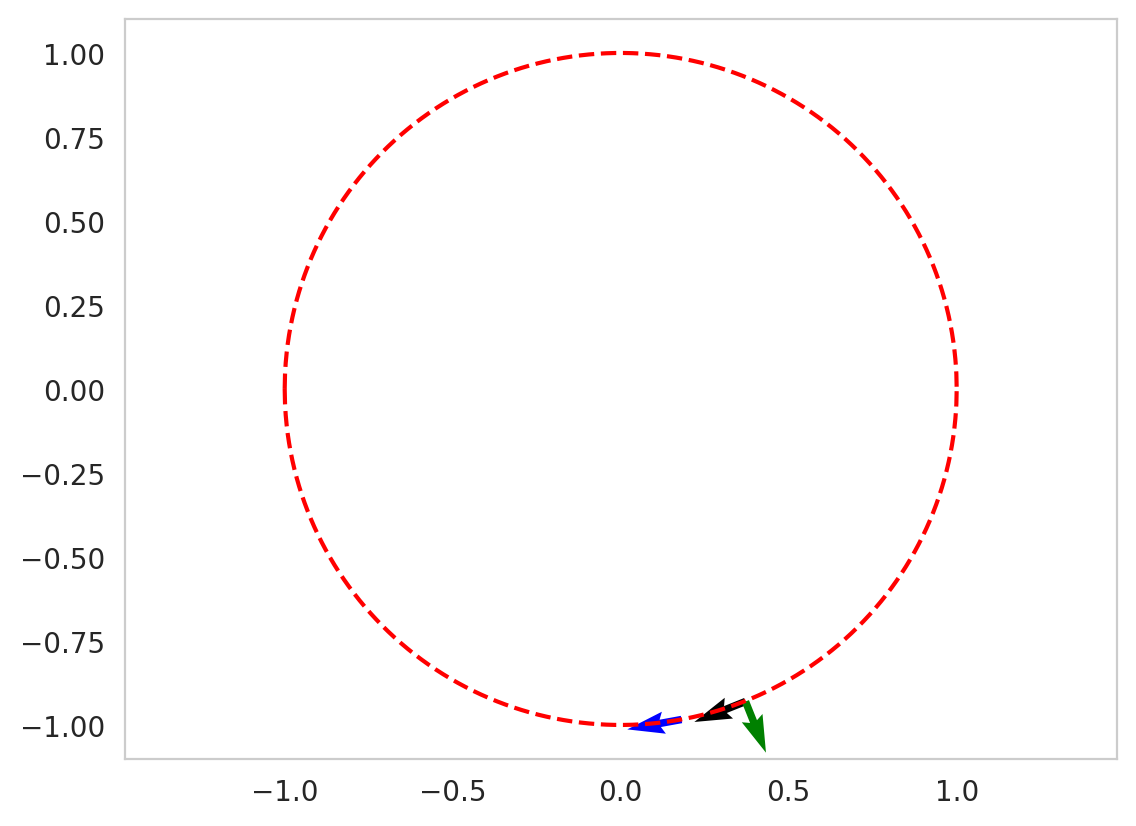

In [18]:
# test
n = random.random() * np.pi * 2
dr = random.choice([-1, 1])
test_point = np.array([np.cos(n), np.sin(n)])
test_dir = dr * normal_2d(test_point)
p_next, dir_next = step_next(test_point, dr * 1, 0.4, test_dir)

plt.axis('equal')
plt.grid(0)
plt.plot(temp_x:= np.linspace(-1, 1, 2000), np.sqrt(1 - temp_x ** 2), "r--")
plt.plot(temp_x:= np.linspace(-1, 1, 2000), -np.sqrt(1 - temp_x ** 2), "r--")
plt.quiver(*test_point, *test_dir)
plt.quiver(*test_point, *normal_2d(test_dir), color="g")
plt.quiver(*p_next, *dir_next, color="b")
plt.show()

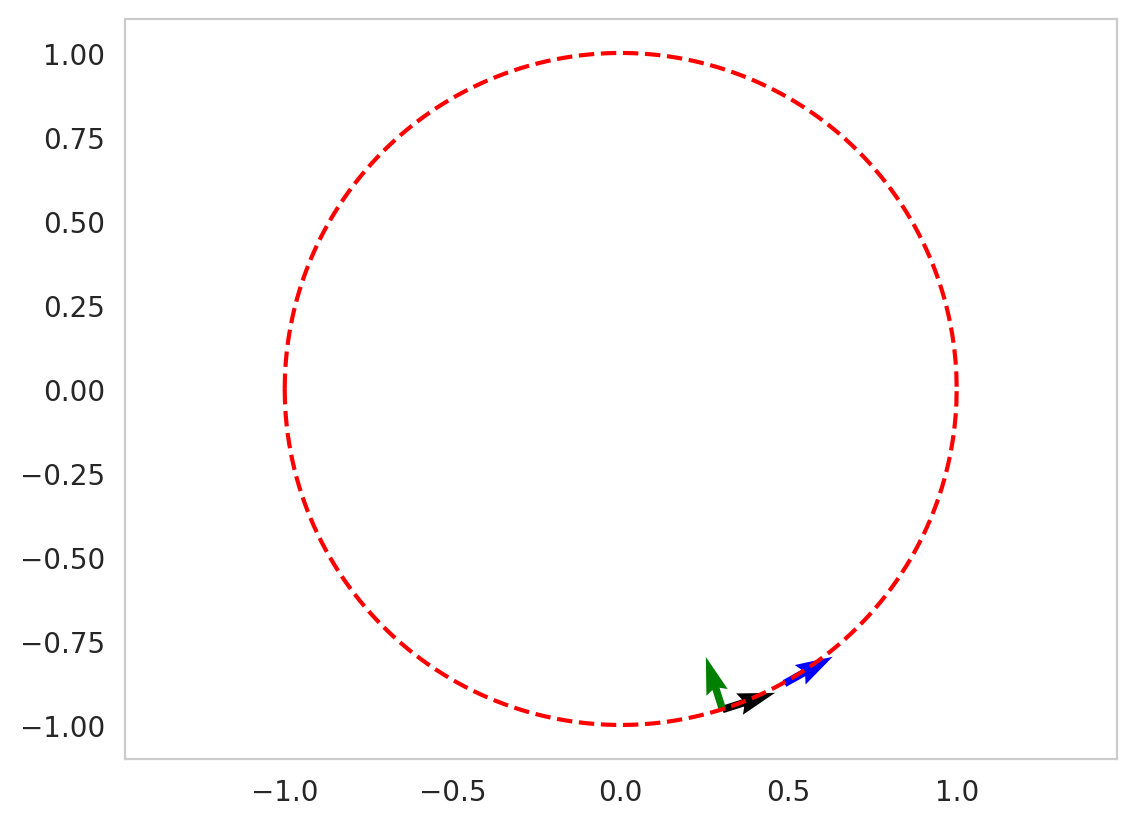

In [19]:
# test2
n = random.random() * np.pi * 2
dr = random.choice([-1, 1])
test_point = np.array([np.cos(n), np.sin(n)])
test_dir = dr * normal_2d(test_point)
p_next, dir_next = step_next(test_point, dr * 1, 0.4, test_dir)

plt.axis('equal')
plt.grid(0)
plt.plot(temp_x:= np.linspace(-1, 1, 2000), np.sqrt(1 - temp_x ** 2), "r--")
plt.plot(temp_x:= np.linspace(-1, 1, 2000), -np.sqrt(1 - temp_x ** 2), "r--")
plt.quiver(*test_point, *test_dir)
plt.quiver(*test_point, *normal_2d(test_dir), color="g")
plt.quiver(*p_next, *dir_next, color="b")
plt.show()

# 激光雷达测试

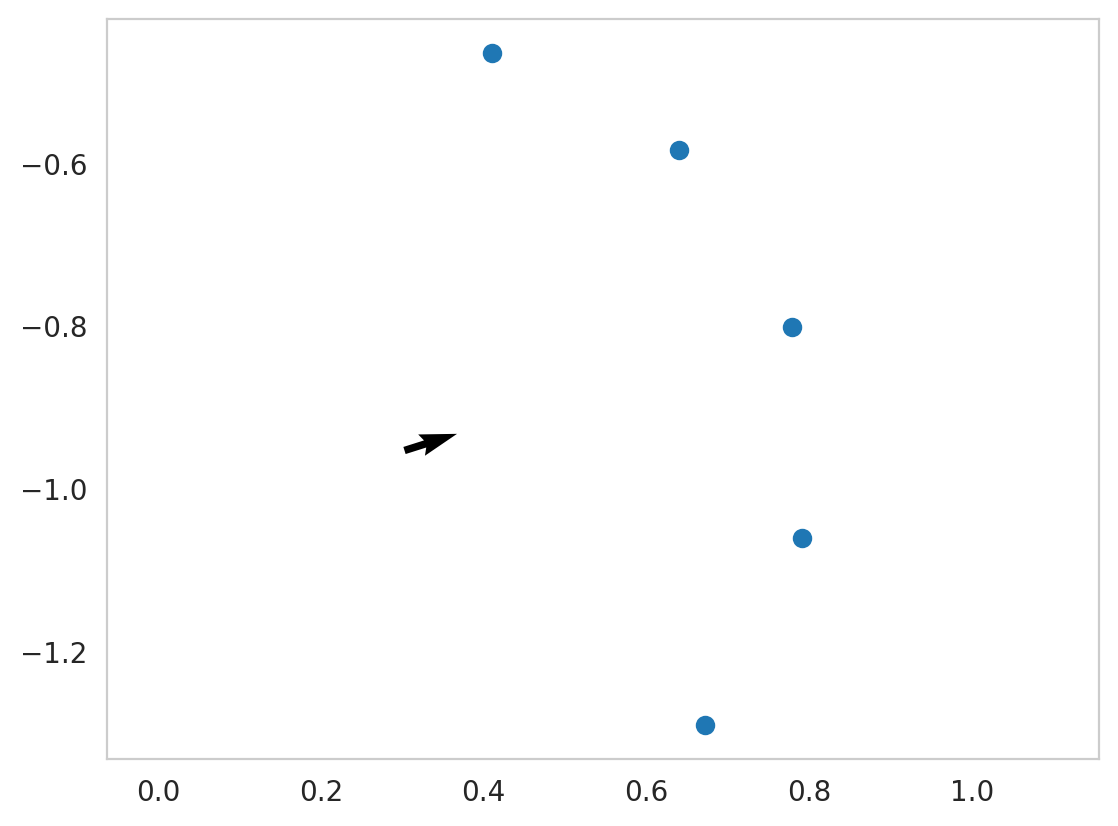

In [20]:
# test radar
theta_dir = dir2theta(test_dir)

plt.axis('equal')
plt.grid(0)
plt.quiver(*test_point, *test_dir)

radar_points = np.zeros((len(radar_directions), 2))

for i, radar_dir in enumerate(radar_directions):
    radar_dir += theta_dir
    radar_points[i] = test_point + r_theta_2_x_y(np.array([0.5, radar_dir]))

plt.scatter(*radar_points.T)

plt.show()

In [21]:
# 检测线段与多边形的交点
# 由于本环境已经可以求得位于哪个区段，检测的多边形可以简化为所在区段以及邻近区段的左右两条线段，最多六条，起点和终点少一个邻近区段，但是要补一条起止线,故只有五条。

# 快速排斥实验
def rect_cross(p1, p2, q1, q2):
    ax, ay = p1
    bx, by = p2
    cx, cy = q1
    dx, dy = q2
    not_ret = max(cx, dx) < min(ax, bx) or \
              max(cy, dy) < min(ay, by) or \
              max(ax, bx) < min(cx, dx) or \
              max(ay, by) < min(cy, dy)

    return not not_ret

# 交点计算
def point_cross(p1, p2, q1, q2):
    if not rect_cross(p1, p2, q1, q2):
        return False, np.array([0, 0])

    dp = p2 - p1
    dq = q2 - q1

    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = q1

    b1 = dp[1] * x1 - dp[0] * y1
    b2 = dq[1] * x3 - dq[0] * y3
    d = dp[0] * dq[1] - dq[0] * dp[1]
    d1 = b2 * dp[0] - b1 * dq[0]
    d2 = b2 * dp[1] - b1 * dq[1]

    x0 = d1 / d
    if min(x1, x2) <= x0 <= max(x1, x2):
        return True, np.array([x0, d2 / d])
    return False, np.array([0, 0])


def radar_observe(point, direction, radar_dirs, ind, road_pts):
    radar_pts = np.vstack([point] * len(radar_dirs))
    r_theta = np.ones((len(radar_dirs), 2)) * path_width * 2
    r_theta[..., 1] = np.array(radar_dirs) + dir2theta(direction)
    radar_pts += r_theta_2_x_y(r_theta)

    result = np.zeros((len(radar_dirs), 3))
    result[..., :2] = radar_pts.copy()
    result[..., 2] = path_width * 2

    if ind == 0:
        pts_l = [0, 1, 2]
        pts_r = [-4, -3, -2, -1]
    elif ind == len(road_pts) // 2 - 2:
        pts_l = [ind - 1, ind, ind + 1, ind + 2]
        pts_r = [ind + 2, ind + 3, ind + 4]
    else:
        pts_l = [ind - 1, ind, ind + 1, ind + 2]
        pts_r = [-1 - ind, -2 - ind, -3 - ind, -4 - ind]

    for i, radar_pt in enumerate(radar_pts):
        for j in range(len(pts_l) - 1):
            q1 = road_pts[pts_l[j]]
            q2 = road_pts[pts_l[j+1]]
            cb, cp = point_cross(point, radar_pt, q1, q2)
            if cb and (r:= mod(cp-point)) < result[i, 2]:
                result[i, :2] = cp
                result[i, 2] = r
        for j in range(len(pts_r) - 1):
            q1 = road_pts[pts_r[j]]
            q2 = road_pts[pts_r[j+1]]
            cb, cp = point_cross(point, radar_pt, q1, q2)
            if cb and (r:= mod(cp-point)) < result[i, 2]:
                result[i, :2] = cp
                result[i, 2] = r

    return result

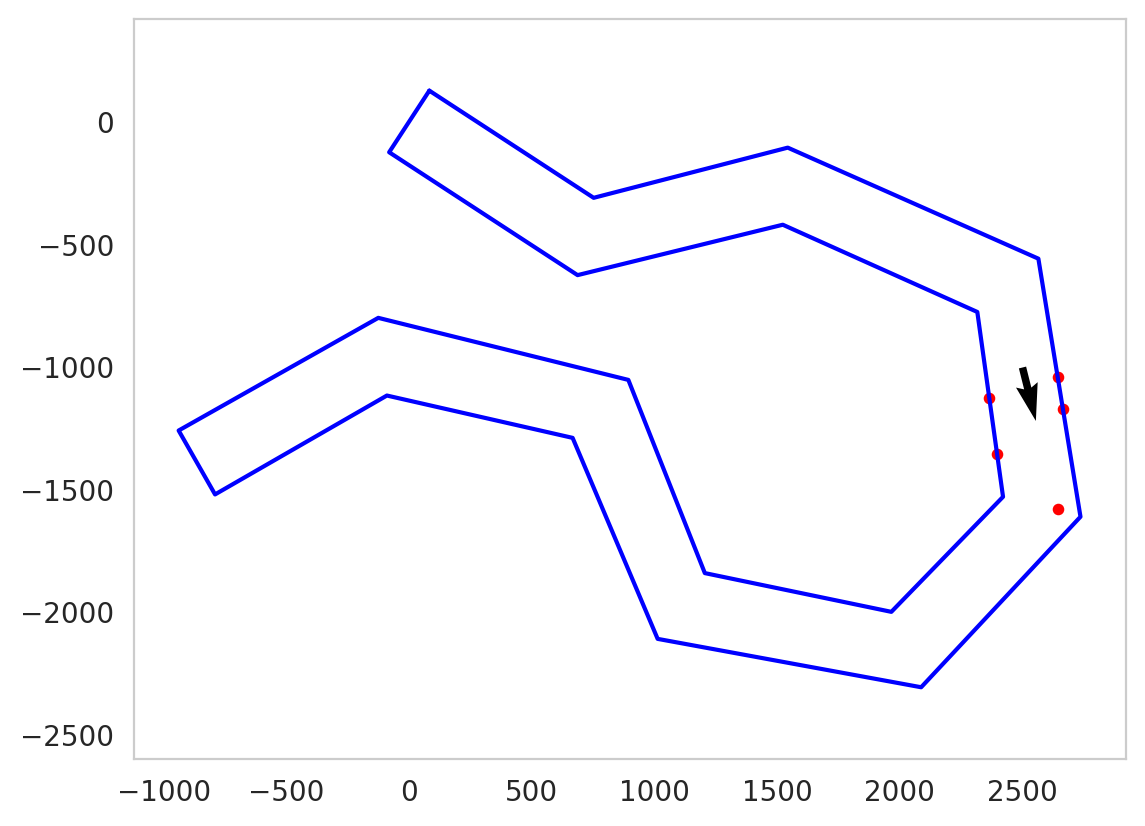

In [22]:
# test
test_point = np.array([2500, -1000]).astype(np.float64)
test_dir = np.array(dir_e(np.array([1, -4])))
path_ind = in_road(test_point, road_polygon)
# path_ind, _, _ = completion(test_point, road_polygon, path_direction, path_points)
radar_result = radar_observe(test_point, test_dir, radar_directions, path_ind, road_polygon)

plt.axis('equal')
plt.grid(0)
plt.plot(*road_polygon.T, c="b")
plt.quiver(*test_point, *test_dir)
plt.scatter(*radar_result[..., :2].T, c="r", s=10)

plt.show()
# radar_result[..., -1]

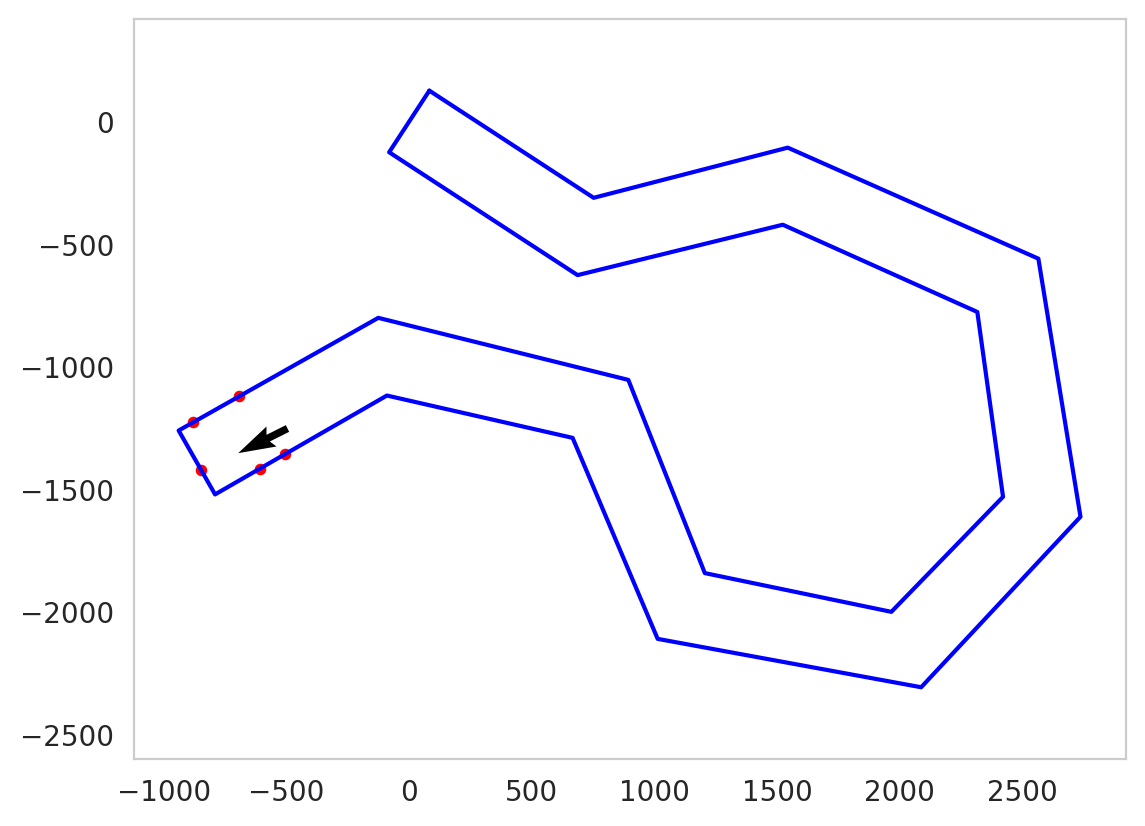

In [23]:
# test2
test_point = np.array([-500, -1250]).astype(np.float64)
test_dir = np.array(dir_e(np.array([-2, -1])))
path_ind, _, _ = completion(test_point, road_polygon, path_direction, path_points)
radar_result = radar_observe(test_point, test_dir, radar_directions, path_ind, road_polygon)

plt.axis('equal')
plt.grid(0)
plt.plot(*road_polygon.T, c="b")
plt.quiver(*test_point, *test_dir)
plt.scatter(*radar_result[..., :2].T, c="r", s=10)

plt.show()
# radar_result[..., -1]

# 牛逼！！！！！

# 环境基本over，开始封装environment,agent,utils

In [24]:
# 环境基本over，开始封装
from environment import *
from agent import *
set_seed()

In [25]:
env = Environment(6000)
car = Agent()

In [26]:
car.set_pos_dir_v(env.path_points[1] / 10, theta_e(path_direction[0, 1]+0.01), 0)
comp = env.completion(car.position)
observation = env.observe(car)
print(*comp, observation[0])
print(car.digitize_state((observation[1].T[-1], 30)), car.num_states, car.num_radar_states)
observation[1]

0 71.9 71.9 True
267520 295245 59049


array([[ 187.56964603,   26.90167388,  143.51616589],
       [ 305.73752996,  -50.16861714,  245.75574427],
       [ 481.73202202, -308.22114462,  500.        ],
       [ 177.54402421, -265.03250844,  254.41931929],
       [  53.78955531, -184.31859011,  145.18302702]])

# Agent、 Env测试

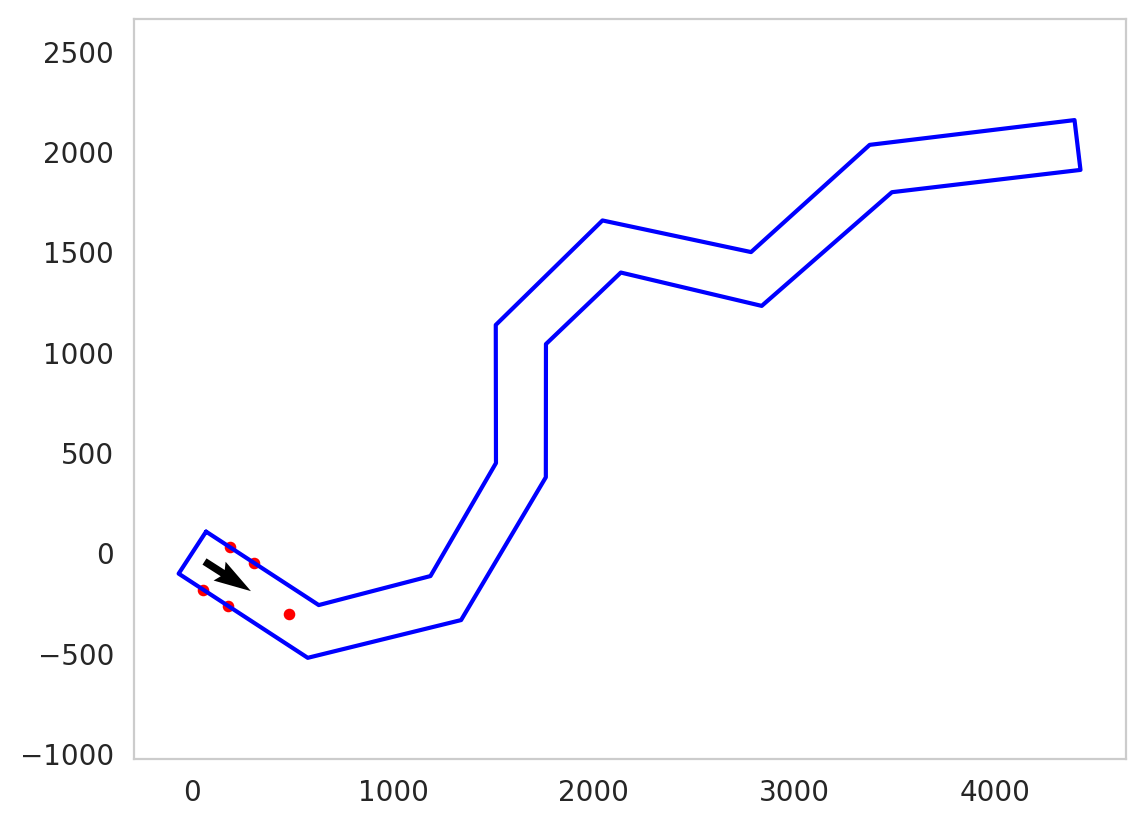

In [27]:
plt.axis('equal')
plt.grid(0)
plt.plot(*env.road_polygon.T, c="b")
plt.quiver(*car.position, *car.direction)
plt.scatter(*observation[1][..., :2].T, c="r", s=10)
plt.show()

# 速度、轨迹以及环境测试

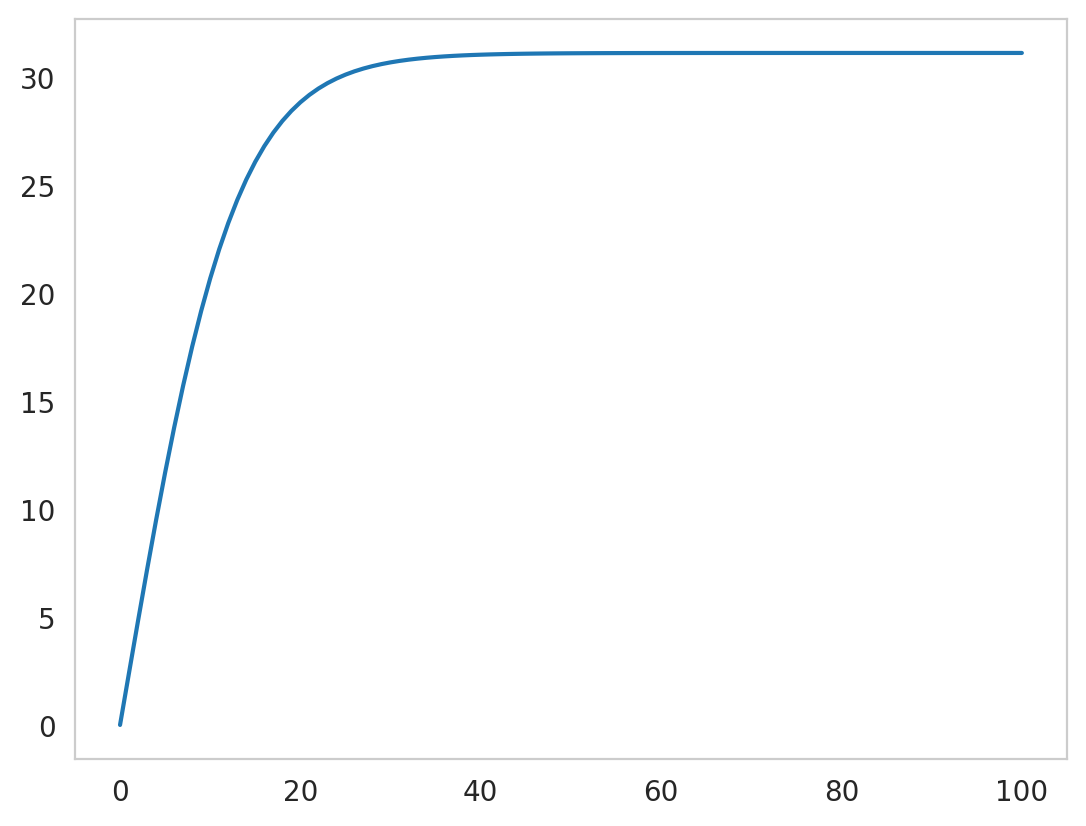

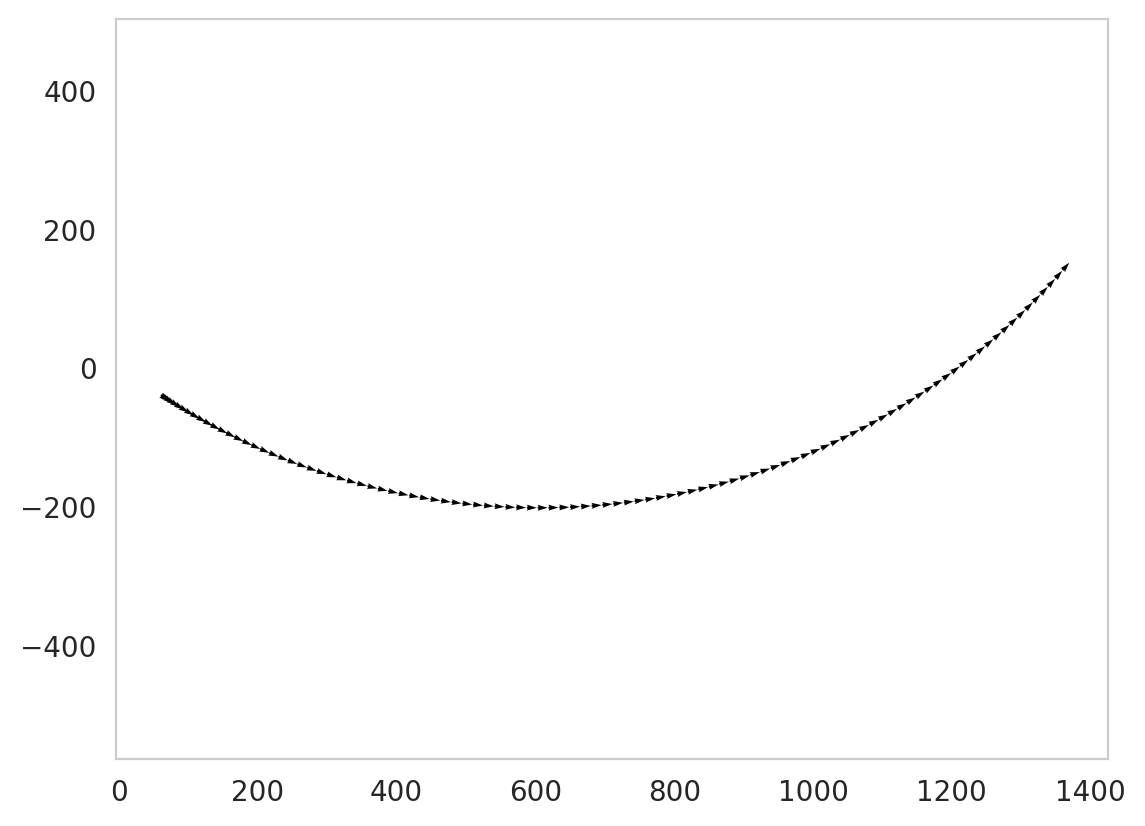

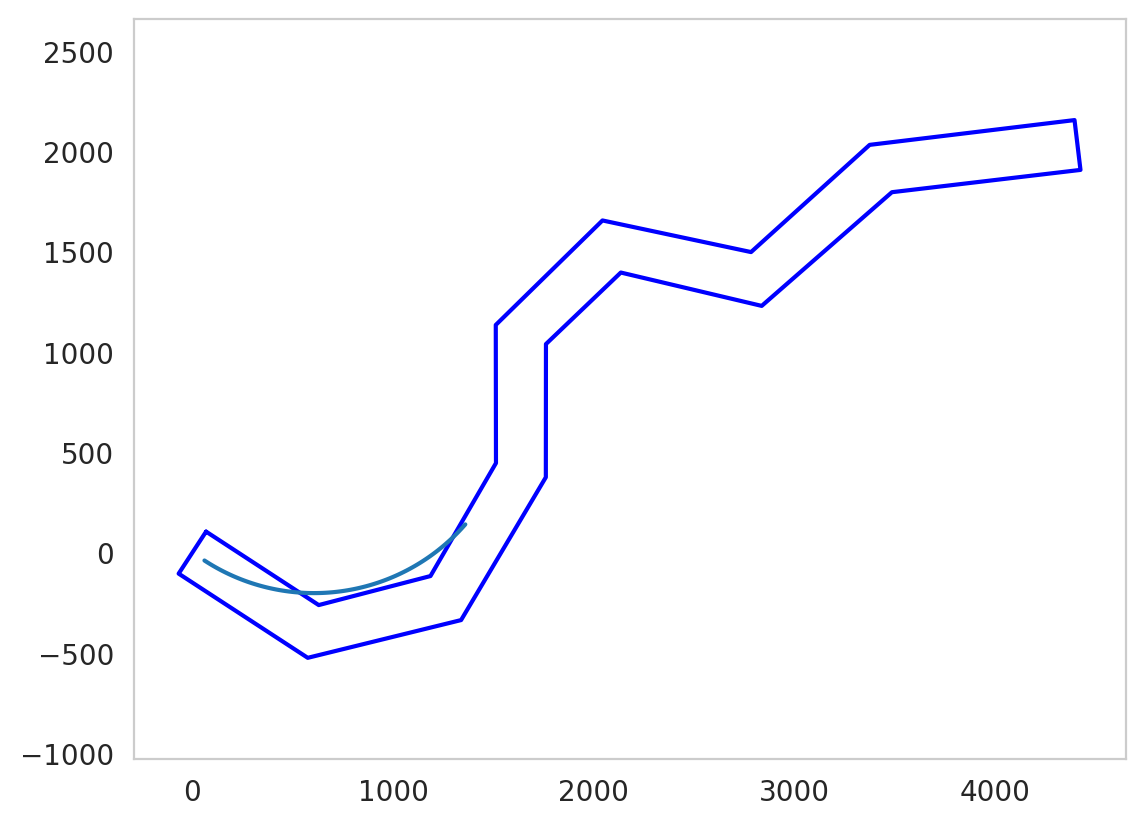

In [28]:
car.clear_hist()
car.set_pos_dir_v(env.path_points[1] / 10, theta_e(path_direction[0, 1]), 0)

for i in range(100):
    car.run_one_step(1.0, car.action_space_r[2])
    car.store_hist()

hist = car.get_hist()
plot(hist.T[-1])

plt.axis('equal')
plt.grid(0)
plt.quiver(*hist.T[:4], scale=100)
plt.show()

plt.axis('equal')
plt.grid(0)
plt.plot(*env.road_polygon.T, c="b")
plt.plot(*hist.T[:2])
plt.show()

# 进一步训练请去[train.py](./train.py)
# 看结果分析请打开[eval_test.ipynb](./eval_test.ipynb)